<a href="https://colab.research.google.com/github/its-safi/DeepLearning_Homeworks/blob/main/code02_CIFAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Nets and CIFAR-10


There are a number of goals of this notebook:

1.   Learning to put together a basic model beyond what we did in the previous notebook. Main emphasis: new layers, including convolution, max pooling and average pooling. 
2.   Learning the basics of training.
3.   Learning basics of loading data and visualizing.
4.   Learning the basics of printing out a model.
5.   Learning the basics of loading a model.


Also useful to see
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html



<img src="https://miro.medium.com/max/2510/1*vkQ0hXDaQv57sALXAJquxA.jpeg" width=1024px/>

# Problem 1
Read through the tensorboard documentation here to understand what it can do.
https://pytorch.org/docs/stable/tensorboard.html

We will start using this next time.

In [1]:
import torchvision
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.nn.functional as F


classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

batch_size = 4

# the tutorial calls the dataloader twice -- this code defines a function
# that will do this for the train/test data.

def fetch_dataloader(batch_size, transform=None, is_train=True):
    """
    Loads data from disk and returns a data_loader.
    A DataLoader is similar to a list of (image, label) tuples.
    It is used to avoid loading all of the data into memory.
    This is particularly useful for large data sets.
    """
    data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

    # Custom train/val split.
    indices = [i for i in range(len(data)) if (i%10 > 0) == is_train]

    data = torch.utils.data.Subset(data, indices)
    loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, num_workers=2)
    return loader


train_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

val_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

data_train = fetch_dataloader(batch_size, train_transform, is_train=True)
data_val = fetch_dataloader(batch_size, val_transform, is_train=False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


tensor(1)


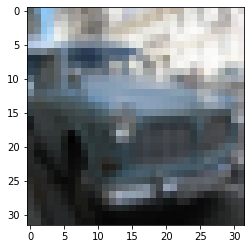

In [4]:
# Displaying an image from the Dataloader.
# The commands below pick a random element from the data set to display.
# See https://towardsdatascience.com/beginners-guide-to-loading-image-data-with-pytorch-289c60b7afec
# and then https://stackoverflow.com/questions/51756581/how-do-i-turn-a-pytorch-dataloader-into-a-numpy-array-to-display-image-data-with


import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid
%matplotlib inline

dataiter = iter(data_train)
images, lables = dataiter.next()
images = images / 2 + 0.5     # unnormalize
plt.imshow(np.transpose(images[0].numpy(), (1, 2, 0)))
print(lables[0])

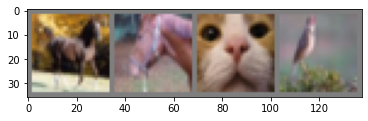

horse horse   cat  bird


In [5]:
# doing the same thing with slighty different syntax from the pytorch tutorial.
# note that the batch-size in dataloader determines the number shown. 
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(data_train)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

## Model Implementation.

Here we will implement a CNN. The following operations will be relevant -

* `torch.nn.Conv2d` 
* `torch.nn.ReLU` 
* `torch.nn.AvgPool2d` 
* `torch.nn.MaxPool2d`

Take a close look at the parameters of `Conv2d`. Play around with the following and see how it affects the output activation map.

* kernel_size
* stride
* padding
* dilation

*Tensorboard*: This is a useful tool to use to understand what's happening during the training and testing process.

Next we see some basic code, similar in spirit to our previous colab notebook, but, critically, adding a new type of layer: a convolutional layer.

In [7]:
# We define two different models, using different syntax.
# CNNClassifier comes from PhilK code_05
# ConvNet comes from the pytorch tutorial linked above. 
# 

class CNNClassifier(torch.nn.Module):
    def __init__(self, input_channels, num_classes):
        """
        Define the layer(s) needed for the model.
        Feel free to define additional input arguments.
        """ 
        super().__init__()
        self.conv = nn.Conv2d(input_channels, 16, 7, 2, 3)
        self.cls = nn.Linear(16, num_classes)
        self.ReLU = nn.ReLU()
        # or could do
        # self.CNN = nn.Sequential(torch.nn.Conv2d(input_channels, 16, 7, 2, 3), torch.nn.ReLU(),torch.nn.Linear(16, num_classes))
    
    # We now define the network.
    # Note also that we don't need to call "forward" --
    # this is just what is done when we call model(x)
    def forward(self, x):
        """
        Calculate the classification score (logits).

        Input: 
            x (float tensor N x 3 x 32 x 32): input images
        Output:
            y (float tensor N x 10): classification scores (logits) for each class
        """
        x = self.conv(x)

        # Add a ReLU
        x = self.ReLU(x)
        # Add global average pooling
        x = x.mean(dim=(2,3))
        return self.cls(x)
    
    # This is all we need here, since self(image) essentially
    # calls the forward step, and then we take the argmax.
    def predict(self, image):
        return self(image).argmax(1)

# From the pytorch tutorial linked above.
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# See Problem 5 below
class ConvNet2(nn.Module):
    def __init__(self):
        super().__init__()
        

    def forward(self, x):
        return x

## Model Training and Validation


In [8]:
# Now we define our model class and then train. 
#

# Define the model we wish to use
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Choose a model to train
model = CNNClassifier(3, 10)
model.to(device)
model.train()

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(data_train, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.211
[1,  4000] loss: 2.071
[1,  6000] loss: 2.007
[1,  8000] loss: 1.970
[1, 10000] loss: 1.924
[2,  2000] loss: 1.874
[2,  4000] loss: 1.837
[2,  6000] loss: 1.835
[2,  8000] loss: 1.837
[2, 10000] loss: 1.806
Finished Training


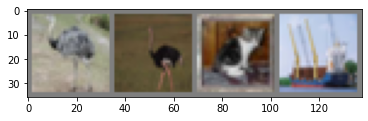

GroundTruth:   bird  bird   cat  ship
Predicted:   bird  frog   dog  ship


In [15]:
# Let's see how well this trained model performs.
dataiter = iter(data_val)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

# and now what our model thinks
images, labels = images.cuda(), labels.cuda() #ADDED EXTRA LINE TO TAKE CARE OF CUDA

predicted = model.predict(images)
# Note that we can do without the .predict and use only forward
# output = model(images)
#_, predicted = torch.max(outputs, 1)


print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

# Problem 2

Assess the accuracy on the data set.

In [18]:
# Assessing accuracy on the entire data set
# It may not look great, but it's better than guessing so it's learning something. 
correct = 0
total = 0

"""
TODO
"""
with torch.no_grad():
    for data in data_val:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 32 %


# Problem 3

Now train the second model and again assess its overall accuracy, and compare to the first model above. 

In [22]:
# Now we train the second model. We see that it does quite a bit better than the first.
#
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Choose a model to train
model = ConvNet()
model.to(device)
model.train()

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(data_train, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

correct = 0
total = 0

"""
TODO
"""
with torch.no_grad():
    for data in data_val:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

[1,  2000] loss: 2.177
[1,  4000] loss: 1.801
[1,  6000] loss: 1.647
[1,  8000] loss: 1.587
[1, 10000] loss: 1.523
[2,  2000] loss: 1.433
[2,  4000] loss: 1.412
[2,  6000] loss: 1.378
[2,  8000] loss: 1.357
[2, 10000] loss: 1.352
Finished Training
Accuracy of the network on the 10000 test images: 52 %




1.   Overall accuracy of first model : 32% 
2.   Overall accuracy of second model: 52%

As expected the second model does better, as it has several convolution layers, and fully connected layers. This architecture allows the model to learn better. 



# Problem 4a

Use "torchsummary" in order to produce a summary of the network you've created, meaning, to produce a summary of what each layer is, its sizes etc., and the number of parameters in each layer. 

In [28]:
# We can see what we've created: 

from torchsummary import summary

summary(model, (3, 10, 10))

RuntimeError: ignored

# Problem 4b

Repeat this on a large network like ResNet18.
This is also an excuse to show you how to load a pre-trained network!

In [ ]:
import torchvision.models as models
# We can now download a pretrained or not pretrained network.
# For example, VGG or RESNET:
# vgg = models.vgg16()

RN18 = models.resnet18(pretrained=True)
# Use torchsummary to print out what each layer is.

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

# Problem 5

Note that when we printed out the summary of our second model above, it didn't show any of the ReLUs. 

Define an equivalent ConvNet2 above, so that summary prints out all the layers, including the ReLU layers.

In [ ]:
# Another very useful approach: we can see the actual names used for each layer by using the following code
for name, layer in model2.named_modules():
    print(name,layer)


 ConvNet2(
  (relu): ReLU()
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
relu ReLU()
conv1 Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
pool MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
conv2 Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
fc1 Linear(in_features=400, out_features=120, bias=True)
fc2 Linear(in_features=120, out_features=84, bias=True)
fc3 Linear(in_features=84, out_features=10, bias=True)


In [ ]:
# And yet another way we can do this:

# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model2.state_dict():
    print(param_tensor, "\t", model2.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
conv1.weight 	 torch.Size([6, 3, 5, 5])
conv1.bias 	 torch.Size([6])
conv2.weight 	 torch.Size([16, 6, 5, 5])
conv2.bias 	 torch.Size([16])
fc1.weight 	 torch.Size([120, 400])
fc1.bias 	 torch.Size([120])
fc2.weight 	 torch.Size([84, 120])
fc2.bias 	 torch.Size([84])
fc3.weight 	 torch.Size([10, 84])
fc3.bias 	 torch.Size([10])
Optimizer's state_dict:
state 	 {0: {'momentum_buffer': tensor([[[[-7.2021e-01, -6.8144e-01, -5.8801e-01, -5.8313e-01, -6.3871e-01],
          [-5.9141e-01, -5.8469e-01, -5.1603e-01, -5.0512e-01, -5.3253e-01],
          [-6.1914e-01, -5.6877e-01, -5.6204e-01, -5.6895e-01, -5.8311e-01],
          [-6.9944e-01, -6.5425e-01, -6.2494e-01, -6.3881e-01, -6.7620e-01],
          [-6.5928e-01, -6.6887e-01, -6.2719e-01, -6.2016e-01, -6.7778e-01]],

         [[-6.5570e-01, -6.0979e-01, -5.0795e-01, -5.0544e-01, -5.7187e-01],
          [-5.9179e-01, -5.7461e-01, -5.0455e-01, -5.0112e-01, -5.4251e-01],
          [-6.7796e-01, -6.2669e-01, -6.1355e-01, -6.

# Problem 6

Extract the data with the first 5 labels. That is, create train and val data loaders but only using the first five labels. (We will use this later for transfer learning.)